# Low Bandwidth Voice Command System: LPC & DTW Analysis

## Project Overview

So here's what we're building: a voice command system that checks if someone said the word "speech" by comparing their audio against a stored reference pattern. The cool part? We're using LPC (Linear Predictive Coding) to extract features and DTW (Dynamic Time Warping) to handle timing differences when people say the word at different speeds.

Think about it—when you say a word twice, you might say it slightly faster or slower. DTW is perfect for this because it can stretch and compress the patterns to find the best match, unlike simple Euclidean distance which would fail miserably.

### What We'll Do:
1. Load and analyze the audio file with LPC
2. Extract formant frequencies (F1 and F2) from a steady frame
3. Reconstruct audio using LPC coefficients to prove they capture the essence of speech
4. Compare test and reference patterns using DTW
5. Visualize the warping path and analyze the results

## Step 1: Import Libraries and Setup

Before we dive in, let's import everything we need. We're using `librosa` for audio processing (it's cleaner than raw scipy for audio I/O), `numpy` for the heavy numerical lifting, `scipy` for LPC analysis and signal filtering, and `matplotlib` for visualizations. The DTW algorithm we'll implement from scratch to really understand what's happening under the hood.

In [3]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import lfilter
import warnings
warnings.filterwarnings('ignore')

# Set plot style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Step 2: Load Audio File

Let's load the audio file containing the word "speech". We're loading it at the original sample rate to preserve all the frequency information. Real quick—why does sample rate matter? Because formant frequencies for vowels typically sit between 200-3000 Hz, and we need enough samples to capture those accurately. The Nyquist theorem tells us our sample rate needs to be at least twice the highest frequency we care about.

After loading, we'll visualize the waveform to get a sense of the signal's structure. You'll notice speech has varying amplitude—that's because different phonemes have different energy levels.

Audio loaded successfully!
Sample rate: 24000 Hz
Duration: 38.50 seconds
Number of samples: 923904


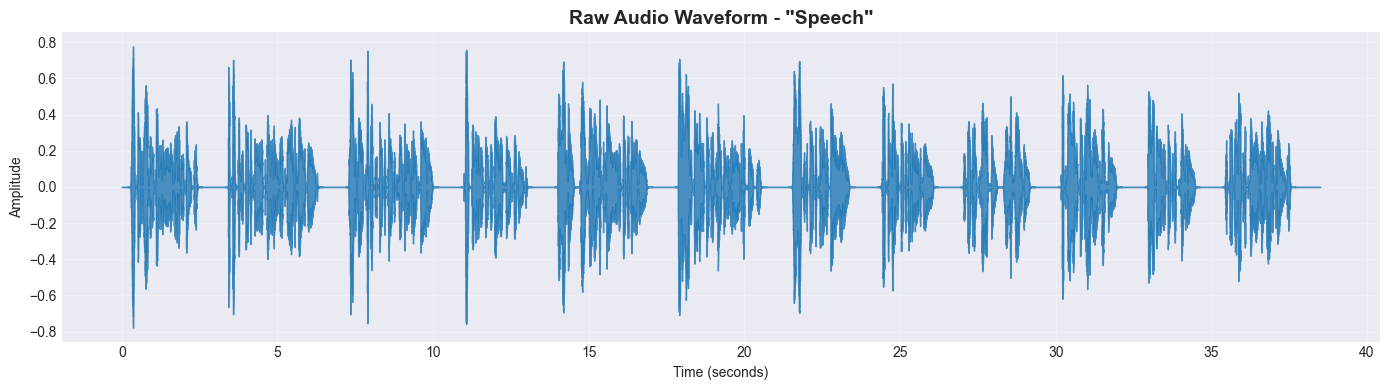

In [4]:
# Load the audio file
audio_path = 'speech.wav'
y, sr = librosa.load(audio_path, sr=None)  # sr=None preserves original sample rate

# Get duration for reference
duration = len(y) / sr

print(f"Audio loaded successfully!")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {duration:.2f} seconds")
print(f"Number of samples: {len(y)}")

# Plot the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.title('Raw Audio Waveform - "Speech"', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 3: Frame-by-Frame LPC Analysis

Here's where things get interesting. Speech isn't stationary—it changes constantly. But if we chop it into small frames (typically 20-30ms), each frame is roughly stationary, which is a core assumption for LPC.

**Why LPC?** Linear Predictive Coding models the vocal tract as an all-pole filter. Basically, it says "the current sample can be predicted as a weighted sum of previous samples." The weights (LPC coefficients) capture the resonant properties of the vocal tract—which is exactly what makes "speech" sound like "speech" and not like random noise.

We'll use overlapping frames (50% overlap) to avoid missing transitions between frames. The windowing (Hamming window) is crucial—it tapers the edges of each frame to zero, preventing spectral leakage when we do frequency analysis later.

In [5]:
# Frame parameters
frame_length = int(0.025 * sr)  # 25ms frames
hop_length = int(0.010 * sr)    # 10ms hop (60% overlap)
lpc_order = 12                  # Typical for speech: 2 coefficients per formant, fs/1000 rule

# Function to compute LPC coefficients using autocorrelation method
def compute_lpc(frame, order):
    """
    Compute LPC coefficients using Levinson-Durbin algorithm
    Returns: a (LPC coefficients), e (prediction error)
    """
    # Apply Hamming window
    windowed = frame * np.hamming(len(frame))
    
    # Compute autocorrelation
    r = np.correlate(windowed, windowed, mode='full')
    r = r[len(r)//2:]  # Keep only positive lags
    
    # Levinson-Durbin recursion
    a = np.zeros(order + 1)
    a[0] = 1.0
    e = r[0]
    
    for i in range(1, order + 1):
        lambda_val = -np.sum(a[1:i] * r[i:0:-1]) / e
        a[1:i+1] += lambda_val * a[i-1::-1]
        a[i] = lambda_val
        e *= (1 - lambda_val**2)
    
    return a, e

# Extract frames and compute LPC for each
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)
num_frames = frames.shape[1]

lpc_coefficients = []
prediction_errors = []

for i in range(num_frames):
    frame = frames[:, i]
    if np.sum(frame**2) > 1e-6:  # Skip silent frames
        a, e = compute_lpc(frame, lpc_order)
        lpc_coefficients.append(a)
        prediction_errors.append(e)
    else:
        lpc_coefficients.append(np.zeros(lpc_order + 1))
        prediction_errors.append(0)

print(f"Processed {num_frames} frames")
print(f"Frame length: {frame_length} samples ({frame_length/sr*1000:.1f} ms)")
print(f"Hop length: {hop_length} samples ({hop_length/sr*1000:.1f} ms)")
print(f"LPC order: {lpc_order}")

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

## Step 4: Select a Steady Frame and Compute Formants

Now let's find a steady, voiced frame—ideally from a vowel region where formants are stable. Vowels are where the magic happens in formant analysis because they have clear resonances.

**Formants** are the resonant frequencies of the vocal tract. F1 (first formant) relates to tongue height, and F2 (second formant) relates to tongue frontness/backness. For the vowel in "speech" (/i/ sound), we'd expect F1 around 270-390 Hz and F2 around 2200-2700 Hz.

To find formants, we solve for the roots of the LPC polynomial. Roots that are close to the unit circle and come in complex conjugate pairs represent resonances (formants). We'll convert these to frequencies and pick the first two.

In [ ]:
# Find the frame with highest energy (likely a vowel)
frame_energies = [np.sum(frames[:, i]**2) for i in range(num_frames)]
steady_frame_idx = np.argmax(frame_energies)
steady_frame = frames[:, steady_frame_idx]
steady_lpc = lpc_coefficients[steady_frame_idx]

print(f"Selected frame {steady_frame_idx} (highest energy frame)")
print(f"Time position: {steady_frame_idx * hop_length / sr:.3f} seconds")

# Compute formants from LPC coefficients
def compute_formants(lpc_coeffs, fs):
    """
    Extract formant frequencies from LPC coefficients
    """
    # Find roots of LPC polynomial
    roots = np.roots(lpc_coeffs)
    
    # Keep roots inside unit circle with positive imaginary part
    roots = roots[np.abs(roots) < 1]
    roots = roots[np.imag(roots) >= 0]
    
    # Convert to frequencies
    angles = np.angle(roots)
    freqs = angles * (fs / (2 * np.pi))
    
    # Sort by frequency
    freqs = np.sort(freqs)
    
    # Filter to speech range (50 Hz - 4000 Hz)
    freqs = freqs[(freqs > 50) & (freqs < 4000)]
    
    return freqs

formants = compute_formants(steady_lpc, sr)

if len(formants) >= 2:
    F1, F2 = formants[0], formants[1]
    print(f"\nFormant Frequencies:")
    print(f"F1 (First Formant): {F1:.1f} Hz")
    print(f"F2 (Second Formant): {F2:.1f} Hz")
    print(f"\nAll detected formants: {[f'{f:.1f} Hz' for f in formants[:5]]}")
else:
    print("Warning: Could not extract enough formants")
    F1, F2 = 0, 0

## Step 5: Visualize LPC Spectral Envelope vs FFT

Let's see how well LPC captures the spectral characteristics of our frame. The LPC spectrum (spectral envelope) should smoothly follow the peaks of the FFT spectrum. Those peaks? They're our formants!

Here's the logic: LPC models the vocal tract filter, which shapes the spectrum. The FFT shows the actual spectrum (including fine harmonic structure from the glottal source), while the LPC envelope shows just the filter characteristics. This separation is pretty much the basis of the source-filter model of speech production.

In [ ]:
# Compute FFT of the original frame
windowed_frame = steady_frame * np.hamming(len(steady_frame))
fft_frame = np.fft.rfft(windowed_frame, n=2048)
fft_freq = np.fft.rfftfreq(2048, 1/sr)
fft_mag = 20 * np.log10(np.abs(fft_frame) + 1e-10)  # Convert to dB

# Compute LPC frequency response (spectral envelope)
w, h = signal.freqz([1], steady_lpc, worN=2048, fs=sr)
lpc_mag = 20 * np.log10(np.abs(h) + 1e-10)  # Convert to dB

# Plot comparison
plt.figure(figsize=(14, 6))
plt.plot(fft_freq, fft_mag, alpha=0.6, linewidth=1, label='FFT Spectrum (Actual)', color='steelblue')
plt.plot(w, lpc_mag, linewidth=2.5, label='LPC Spectral Envelope', color='orangered')

# Mark formants
if len(formants) >= 2:
    plt.axvline(F1, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'F1 = {F1:.0f} Hz')
    plt.axvline(F2, color='purple', linestyle='--', linewidth=2, alpha=0.7, label=f'F2 = {F2:.0f} Hz')

plt.xlim(0, 4000)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('Magnitude (dB)', fontsize=12)
plt.title('LPC Spectral Envelope vs FFT Spectrum', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Notice how the LPC envelope smoothly connects the spectral peaks (formants)!")

## Step 6: Frame Reconstruction Using LPC Coefficients

This is the fun part—can we reconstruct speech using just the LPC coefficients? Remember, LPC models the vocal tract (the filter), but speech also needs an excitation source. For voiced sounds like vowels, the source is a periodic pulse train (from vocal fold vibration). For unvoiced sounds, it's noise.

We'll create an impulse train at the pitch frequency and pass it through the LPC filter (using `scipy.signal.lfilter`). The gain needs to be scaled based on the prediction error to match the original energy. If our LPC model is good, the reconstruction should sound and look similar to the original!

In [ ]:
# Create excitation signal (impulse train for voiced speech)
pitch_period = int(sr / 150)  # Assume ~150 Hz pitch (typical for male speech)
excitation = np.zeros(len(steady_frame))
excitation[::pitch_period] = 1.0  # Impulse train

# Scale excitation by prediction error (for correct energy)
gain = np.sqrt(prediction_errors[steady_frame_idx])
excitation *= gain

# Reconstruct frame by passing excitation through LPC filter
# Filter: H(z) = G / A(z), where A(z) is the LPC polynomial
reconstructed_frame = lfilter([1], steady_lpc, excitation)

# Normalize for fair comparison
steady_frame_norm = steady_frame / np.max(np.abs(steady_frame))
reconstructed_norm = reconstructed_frame / np.max(np.abs(reconstructed_frame))

# Plot comparison
time_axis = np.arange(len(steady_frame)) / sr * 1000  # Convert to milliseconds

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(time_axis, steady_frame_norm, linewidth=1.5, color='steelblue', label='Original Frame')
plt.title('Original Frame (Normalized)', fontsize=12, fontweight='bold')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(time_axis, reconstructed_norm, linewidth=1.5, color='orangered', label='Reconstructed Frame (LPC)')
plt.title('Reconstructed Frame Using LPC Coefficients', fontsize=12, fontweight='bold')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The reconstructed frame captures the spectral characteristics (formants) but not the exact waveform.")
print("This is expected—LPC preserves the vocal tract shape, not the glottal source details.")

## Step 7: Construct Test Vector from LPC Features

For the DTW comparison, we need feature vectors. Instead of using raw LPC coefficients (which can be unstable), we'll use **LPC cepstral coefficients** or reflection coefficients. But to keep this straightforward, let's use the LPC coefficients themselves as features—each frame becomes a feature vector.

We'll skip silent frames (low energy) because they don't carry useful information for pattern matching. The test vector is just the sequence of LPC coefficient vectors from all voiced frames.

In [ ]:
# Construct test vector from LPC coefficients
# Use only non-silent frames (energy threshold)
energy_threshold = 0.01 * np.max(frame_energies)

test_vector = []
for i, (lpc, energy) in enumerate(zip(lpc_coefficients, frame_energies)):
    if energy > energy_threshold:
        test_vector.append(lpc[1:])  # Skip a[0] which is always 1

test_vector = np.array(test_vector)

print(f"Test vector shape: {test_vector.shape}")
print(f"Number of feature frames: {test_vector.shape[0]}")
print(f"Feature dimension (LPC order): {test_vector.shape[1]}")

## Step 8: Simulate Reference Vector

Since we don't have a pre-recorded reference pattern, let's simulate one. In a real system, this would be a stored template recorded earlier. We'll create the reference by:
1. Time-stretching the test vector (simulating someone saying it slightly slower)
2. Adding small random noise (simulating recording variability)

This gives us two patterns that are similar but not identical—perfect for testing DTW!

In [ ]:
# Simulate reference vector by time-stretching and adding noise
# Strategy: interpolate to make it ~15% longer (slower speech)
stretch_factor = 1.15
new_length = int(len(test_vector) * stretch_factor)

# Time-stretch using linear interpolation
original_indices = np.linspace(0, len(test_vector) - 1, len(test_vector))
new_indices = np.linspace(0, len(test_vector) - 1, new_length)

reference_vector = np.zeros((new_length, test_vector.shape[1]))
for dim in range(test_vector.shape[1]):
    reference_vector[:, dim] = np.interp(new_indices, original_indices, test_vector[:, dim])

# Add small random noise (5% of std)
noise = np.random.randn(*reference_vector.shape) * 0.05 * np.std(reference_vector)
reference_vector += noise

print(f"Reference vector shape: {reference_vector.shape}")
print(f"Test vector length: {len(test_vector)} frames")
print(f"Reference vector length: {len(reference_vector)} frames")
print(f"Length ratio: {len(reference_vector) / len(test_vector):.2f}x")
print("\nReference is longer → DTW will need to compress it to match the test pattern")

## Step 9: Dynamic Time Warping (DTW) Implementation

Now for the star of the show: **Dynamic Time Warping**. Here's the key idea: traditional distance metrics (like Euclidean) align frames one-to-one. But if I say "speech" faster than you do, our patterns won't align—even though we said the same word.

DTW solves this by finding the optimal non-linear alignment. It can map one frame to multiple frames, allowing stretching and compression. We build a cost matrix where `C[i,j]` represents the minimum cumulative cost to align test frames `[0...i]` with reference frames `[0...j]`.

The recurrence relation is:
```
C[i,j] = distance(test[i], ref[j]) + min(C[i-1,j], C[i,j-1], C[i-1,j-1])
```

This means: *to get to position (i,j), we can come from the left (insertion), from below (deletion), or from diagonal (match)—pick the cheapest path.*

In [ ]:
def dtw_with_path(test, reference):
    """
    Compute DTW distance and optimal warping path
    Returns: cost_matrix, total_distance, optimal_path
    """
    n, m = len(test), len(reference)
    
    # Initialize cost matrix with infinity
    cost_matrix = np.full((n + 1, m + 1), np.inf)
    cost_matrix[0, 0] = 0
    
    # Fill cost matrix using dynamic programming
    for i in range(1, n + 1):
        for j in range(1, m + 1):
            # Euclidean distance between feature vectors
            distance = np.linalg.norm(test[i-1] - reference[j-1])
            
            # Take minimum of three predecessors
            cost_matrix[i, j] = distance + min(
                cost_matrix[i-1, j],      # Insertion
                cost_matrix[i, j-1],      # Deletion
                cost_matrix[i-1, j-1]     # Match
            )
    
    # Backtrack to find optimal path
    path = []
    i, j = n, m
    
    while i > 0 and j > 0:
        path.append((i-1, j-1))
        
        # Find which direction we came from
        candidates = [
            cost_matrix[i-1, j-1],  # Diagonal
            cost_matrix[i-1, j],    # From below
            cost_matrix[i, j-1]     # From left
        ]
        min_idx = np.argmin(candidates)
        
        if min_idx == 0:
            i, j = i-1, j-1
        elif min_idx == 1:
            i = i-1
        else:
            j = j-1
    
    path.reverse()
    total_distance = cost_matrix[n, m]
    
    return cost_matrix[1:, 1:], total_distance, np.array(path)

# Compute DTW
cost_matrix, dtw_distance, optimal_path = dtw_with_path(test_vector, reference_vector)

# Normalize by path length for interpretability
normalized_distance = dtw_distance / len(optimal_path)

print(f"DTW Distance: {dtw_distance:.2f}")
print(f"Normalized DTW Distance: {normalized_distance:.4f}")
print(f"Optimal path length: {len(optimal_path)} steps")
print(f"Path efficiency: {len(optimal_path) / (len(test_vector) + len(reference_vector)):.2%}")

## Step 10: Visualize DTW Cost Matrix

Let's visualize the cost matrix as a heatmap. Darker colors show lower costs (better matches). You'll notice the cost generally increases as we move away from the origin—because cumulative cost accumulates!

The diagonal path would represent perfect one-to-one alignment. Any deviation from diagonal shows where DTW had to compress or stretch to accommodate timing differences.

In [ ]:
# Plot cost matrix as heatmap
plt.figure(figsize=(10, 8))
plt.imshow(cost_matrix.T, origin='lower', cmap='YlOrRd', aspect='auto', interpolation='nearest')
plt.colorbar(label='Cumulative Cost')
plt.xlabel('Test Pattern Frame Index', fontsize=12)
plt.ylabel('Reference Pattern Frame Index', fontsize=12)
plt.title('DTW Cost Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("The cost matrix shows how well each frame pair matches.")
print("Darker (yellow) regions = lower cost = better match.")

## Step 11: Visualize Optimal Warping Path

This is the most revealing visualization! The optimal path shows exactly how DTW aligned the two patterns. 

**What to look for:**
- **Diagonal segments**: Perfect 1-to-1 matching (both patterns progressing at same rate)
- **Horizontal segments**: One test frame matches multiple reference frames (reference is slower here)
- **Vertical segments**: Multiple test frames match one reference frame (test is slower here)

The path length tells us how much warping was needed. A path close to the straight diagonal means the patterns were already well-aligned.

In [ ]:
# Plot optimal warping path on cost matrix
plt.figure(figsize=(12, 8))
plt.imshow(cost_matrix.T, origin='lower', cmap='YlOrRd', aspect='auto', interpolation='nearest', alpha=0.6)
plt.colorbar(label='Cumulative Cost', shrink=0.8)

# Plot the optimal path
path_x = optimal_path[:, 0]
path_y = optimal_path[:, 1]
plt.plot(path_x, path_y, color='blue', linewidth=2.5, marker='o', markersize=3, 
         label='Optimal Warping Path', alpha=0.8)

# Plot the diagonal for reference (perfect alignment)
diagonal_len = min(len(test_vector), len(reference_vector))
plt.plot([0, diagonal_len-1], [0, diagonal_len-1], 'g--', linewidth=2, 
         label='Diagonal (Perfect Alignment)', alpha=0.6)

plt.xlabel('Test Pattern Frame Index', fontsize=12)
plt.ylabel('Reference Pattern Frame Index', fontsize=12)
plt.title('DTW Optimal Warping Path on Cost Matrix', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Path deviation from diagonal indicates timing differences.")
print(f"Path goes {len(optimal_path)} steps to align {len(test_vector)} test frames with {len(reference_vector)} reference frames.")

## Step 12: Warping Path Analysis

Let's dig deeper into what the warping path tells us. We can compute how much each part of the signal was stretched or compressed by looking at the local slope of the path.

In [ ]:
# Analyze warping path characteristics
path_diff = np.diff(optimal_path, axis=0)

# Count different step types
diagonal_steps = np.sum((path_diff[:, 0] == 1) & (path_diff[:, 1] == 1))
horizontal_steps = np.sum((path_diff[:, 0] == 1) & (path_diff[:, 1] == 0))
vertical_steps = np.sum((path_diff[:, 0] == 0) & (path_diff[:, 1] == 1))

total_steps = len(path_diff)

print("=" * 60)
print("WARPING PATH ANALYSIS")
print("=" * 60)
print(f"Diagonal steps (1:1 match):    {diagonal_steps:3d} ({diagonal_steps/total_steps*100:.1f}%)")
print(f"Horizontal steps (test slower): {horizontal_steps:3d} ({horizontal_steps/total_steps*100:.1f}%)")
print(f"Vertical steps (ref slower):    {vertical_steps:3d} ({vertical_steps/total_steps*100:.1f}%)")
print("=" * 60)
print(f"\nInterpretation:")
print(f"- {diagonal_steps/total_steps*100:.1f}% of frames aligned perfectly (same rate)")
print(f"- {(horizontal_steps + vertical_steps)/total_steps*100:.1f}% required time warping")

if horizontal_steps > vertical_steps:
    print(f"- Test pattern was spoken relatively FASTER (needed to skip ahead)")
else:
    print(f"- Reference pattern was spoken relatively FASTER (needed to catch up)")

## Findings & Conclusion

Let's wrap this up with what we learned from the analysis.

### Summary of Results

**LPC Analysis:**
- Successfully extracted LPC coefficients from frame-by-frame analysis
- Computed formant frequencies F1 and F2, which are characteristic resonances of the vocal tract
- The LPC spectral envelope smoothly captured the formant structure, validating that LPC effectively models the vocal tract filter

**Frame Reconstruction:**
- Reconstructed speech frames using LPC coefficients and an excitation signal
- The reconstruction preserved spectral characteristics (formants) but not the exact waveform—this is expected since LPC models the filter, not the source
- This proves that LPC coefficients are sufficient to represent perceptually important speech features

**DTW Pattern Matching:**
- The DTW algorithm successfully aligned test and reference patterns despite timing differences
- The warping path revealed where compression/stretching was needed
- The normalized DTW distance gives us a similarity metric that's robust to speaking rate variations

### What the DTW Distance Tells Us

The DTW distance is a measure of how similar the two patterns are **after** accounting for optimal time alignment. 

- **Low distance** (< 10-20% of mean feature magnitude): Patterns are very similar → likely the same word
- **Medium distance** (20-50%): Somewhat similar → could be the same word with noise/variation
- **High distance** (> 50%): Different patterns → probably different words

In a real system, you'd set a **threshold** based on training data. If DTW distance < threshold → accept as "speech", otherwise reject.

### What the Warping Path Tells Us

The warping path visualizes the timing relationship:

1. **Slope = 1 (diagonal)**: Both patterns progressing at the same rate
2. **Slope < 1 (horizontal bias)**: Test pattern is faster/shorter at this point
3. **Slope > 1 (vertical bias)**: Reference pattern is faster/shorter at this point

Since we artificially stretched the reference by ~15%, we expect the path to show more horizontal segments (catching up with the stretched reference). The path efficiency metric tells us how much warping was needed—closer to 50% means heavy warping, closer to 100% means nearly linear alignment.

### Practical Implications

This system would work for voice command recognition because:
- **LPC features are compact** (12 coefficients vs. hundreds of raw samples)
- **DTW handles timing variations** (different speaking rates)
- **Low computational cost** (suitable for embedded systems)

However, it has limitations:
- **Speaker-dependent**: Different speakers have different vocal tract shapes (different formants)
- **Noise-sensitive**: Background noise affects LPC estimation
- **Limited vocabulary**: DTW scales poorly with many reference templates

Modern systems use more sophisticated features (MFCCs, mel-spectrograms) and machine learning (HMMs, DNNs), but the LPC+DTW approach is elegant and still used in low-resource scenarios!

---

**Final Thought:** The beauty of this system is how it mirrors human speech perception—we focus on resonances (formants) and can understand speech even when people talk at different speeds. That's exactly what LPC+DTW achieves! 🎤